2. PCA on scanned digits

In [94]:
# read data
import base64
import json
import numpy
def parse(x):
    digit = json.loads(x)
    array = numpy.fromstring(base64.b64decode(digit["data"]), dtype=numpy.ubyte)
    return (digit["label"], array)

digits = sc.textFile("s3n://stat-37601/digits.base64.json").map(parse)
# Separate into training and test data
(digits_training, digits_test) = digits.randomSplit([0.75, 0.25])

First, we write a function to divide the data into the different numbers. 

In [95]:
def get_data_number(data, number):
    return data.filter(lambda(a): a[0]==number).map(lambda d: d[1])

Part (a) Extract principal components.

We standardize the data. Here we follow the example for i=1, that is, the handwritten images of the digit 1. We can set i to different numbers to follow the same analysis.

In [96]:
import numpy as np

#Set number here
i=1

digits_data = get_data_number(digits_training, i)        #Training data for i
digits_data_test = get_data_number(digits_test, i)       #Test data for i
digits_len = digits_data.count()
digits_sum = digits_data.reduce(lambda a,b: np.add(a,b)) #array of sums
digits_mean = np.divide(digits_sum,digits_len)           #array of means

def find_squared_distance(array):
    diff = np.subtract(array,digits_mean)
    return np.square(diff)

digits_sd = digits_data.map(find_squared_distance).reduce(lambda a,b: np.add(a,b))
digits_sd = np.divide(digits_sd,digits_len)             #array of sd
# print(digits_sd)

def standardize(array):
    diff = np.subtract(array,digits_mean)
    return np.divide(diff,digits_sd)

digits_data_reg = digits_data.map(lambda a: standardize(a))

# Extract the digits data as one giant array
digits_all = np.asarray(digits_data_reg.collect())
# dimension is n x d
print digits_all.shape

(5052, 784)


Then we perform PCA. We use the singular value decomposition method.

In [97]:
import numpy as np
U, s, V = np.linalg.svd(digits_all, full_matrices=True)
# print U.shape, V.shape, s.shape   # Dimensions of the three matrices
evs = s**2                          # Note that the eigenvalues are the singular values squared

k = 10
#pc = np.dot(U,np.diag(s))           # How to compute the principal components = the weights of the principal vectors.

# Get the top k principal vectors
def get_pv_k(V, k):
    index = np.argsort(s)[::-1][:k] # indices of the top k singular values
    pv_k = V.T[:,index]
    return pv_k

pv_k = get_pv_k(V,10)           

The first 10 principal components are displayed as images. 

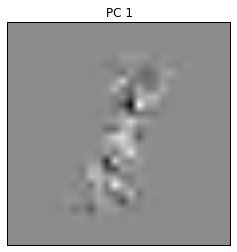

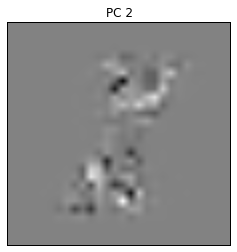

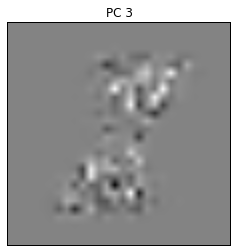

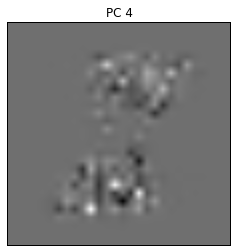

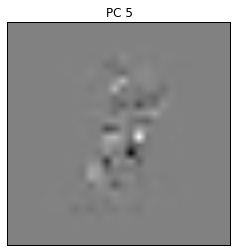

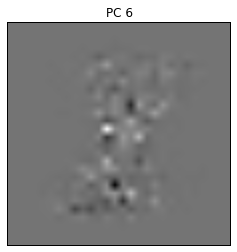

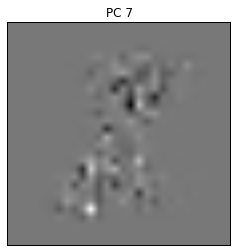

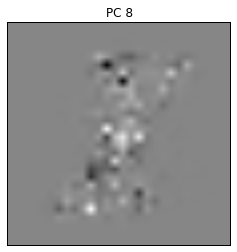

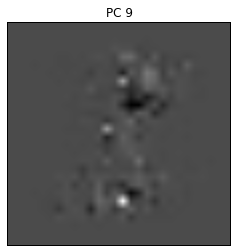

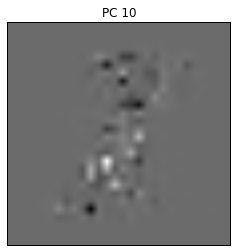

In [98]:
%matplotlib inline
import numpy as np 
from numpy import linalg as LA
import matplotlib.pyplot as plt
pv_k = get_pv_k(V,10)

#Display
for i in range(0,10):
    image = pv_k[:,i]
    image = image.astype(float)/256
    plt.figure()
    plt.title('PC %s' %(i+1))
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.show()

Part (b) Plot Variance of All the Principal Components

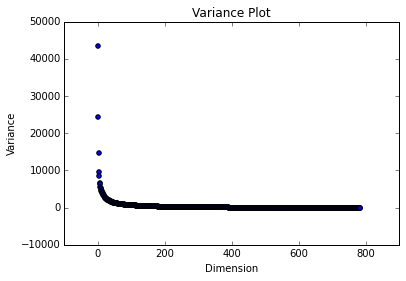

In [99]:
import matplotlib.pyplot as plt

x = range(1,len(s)+1)
plt.scatter(x, s)
plt.xlabel('Dimension')
plt.ylabel('Variance')
plt.title('Variance Plot')
plt.show()

Part (c) Dimension Reduction
Sources:
http://mathworld.wolfram.com/Projection.html

Below, we project onto m components and we tried m=1,21,41,61,81,101. As m increases, the image becomes better at approximating the original image. However, the projections still do not seem to provide a very good representation of the images. The top principal components capture the areas of greatest variation for the digit.

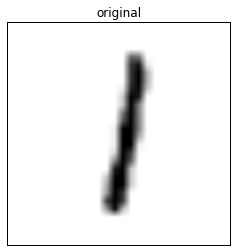

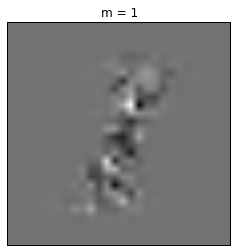

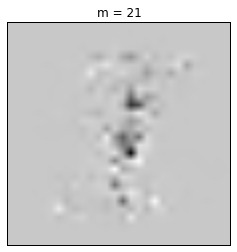

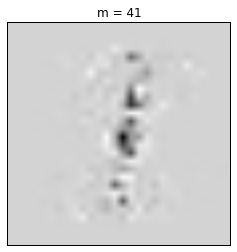

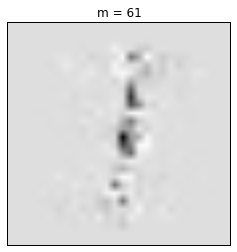

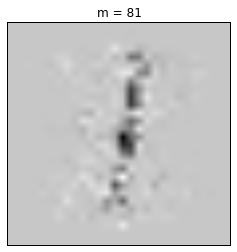

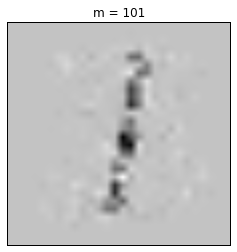

In [100]:
import numpy as np 
from numpy import linalg as LA
import matplotlib.pyplot as plt

point = digits_data_test.takeSample(False,1)         

#Display original point
image = point[0]
image = image.astype(float)/256
plt.figure()
plt.title('original')
fig = plt.imshow(image.reshape(28,28))
fig.set_cmap('gray_r')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

def dim_reduction(pv_k, point):
    pv_k_norm = LA.norm(pv_k)
    projection = np.divide(np.dot(point, pv_k),pv_k_norm**2)
    projection = np.multiply(projection,pv_k)
    # print projection.shape
    projection = projection.mean(axis=1)
    return projection

for k in range(1, (5+1)*20, 20):
    pv_k = get_pv_k(V,k)
  
    #Display
    image = dim_reduction(pv_k, point)
    image = image.astype(float)/256
    plt.figure()
    plt.title('m = %s' %(k))
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

(d) Plot reconstruction error

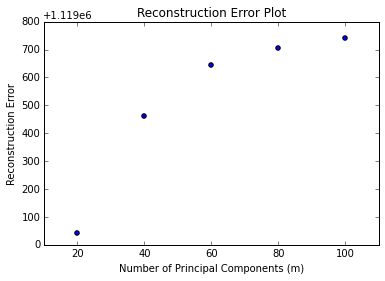

In [102]:
# Find reconstruction error for a data point (point1) and reconstructed image (point2)
def r_error(point1, point2):
    residuals = np.subtract(point1, point2)**2
    return np.sum(residuals)

# Find reconstruction error for the different values of m.
def find_errors(point):
    errors = []
    for k in range(20, (5+1)*20, 20):
        pv_k = get_pv_k(V,k)
        image = dim_reduction(pv_k, point)
        errors.append(r_error(point, image))
    return errors

errors_mean = digits_data_test.map(find_errors).reduce(lambda a,b: np.add(a,b))
errors_mean = errors_mean/digits_len

import matplotlib.pyplot as plt

k = range(20, (5+1)*20, 20)
plt.scatter(k, errors_mean)
plt.xlabel('Number of Principal Components (m)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Plot')
plt.show()
plt.close('all')